In [26]:
# Load required packages
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')
import os


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading the data

In [49]:
csv_file = "/content/drive/MyDrive//Research_hack_example/house_price_regression_dataset.csv"
df = pd.read_csv(csv_file, header=None)
print(df.shape)  # The number of rows and columns

df.head()

(1001, 8)


,0,1,2,3,4,5,6,7
0,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
1,1360,2,1,1981,0.5996366396268326,0,5,262382.8522740563
2,4272,3,3,2016,4.7530138494020395,1,6,985260.854490162
3,3592,1,2,2016,3.634822720478255,0,9,777977.3901185812
4,966,1,2,1977,2.73066687604351,1,8,229698.9186636115


In [51]:
# Run this code only if
# AS the column names are in row 0, see the above cell
# Mkaing the Row 0 as column names

df.columns = df.iloc[0,:].tolist()

df.drop(0,inplace=True)
df.reset_index(inplace=True)
df.drop('index',axis = 1,inplace=True)
df.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.5996366396268326,0,5,262382.8522740563
1,4272,3,3,2016,4.7530138494020395,1,6,985260.854490162
2,3592,1,2,2016,3.634822720478255,0,9,777977.3901185812
3,966,1,2,1977,2.73066687604351,1,8,229698.9186636115
4,4926,2,1,1993,4.699072554837388,0,8,1041740.8589249004


In [52]:
# Now check the data types for numerical and categorical columns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Square_Footage        1000 non-null   object
 1   Num_Bedrooms          1000 non-null   object
 2   Num_Bathrooms         1000 non-null   object
 3   Year_Built            1000 non-null   object
 4   Lot_Size              1000 non-null   object
 5   Garage_Size           1000 non-null   object
 6   Neighborhood_Quality  1000 non-null   object
 7   House_Price           1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB
None


In [55]:
# As you can see the square_footage, Lot_size and House price columns cannot be categorical(Object) because they are numerical, see the output by df.head()
# Converting those three columns back to numerical


cols = ["Square_Footage", "Lot_Size", "House_Price"]
#If you’re OK coercing non-numeric to NaN, convert in one shot
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

print(df[cols].dtypes)



Square_Footage      int64
Lot_Size          float64
House_Price       float64
dtype: object


# Data Exploration

In [56]:
# Separate numeric & categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

In [57]:
# 3) Missing values summary
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(2)
print(missing_counts)
missing_df = pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct})
missing_df = missing_df[missing_df["missing_count"] > 0]

Square_Footage          0
Num_Bedrooms            0
Num_Bathrooms           0
Year_Built              0
Lot_Size                0
Garage_Size             0
Neighborhood_Quality    0
House_Price             0
dtype: int64


In [58]:
# Plot missing values (top 30)
if not missing_df.empty:
    top_missing = missing_df.head(30)
    plt.figure(figsize=(10, 6))
    plt.barh(top_missing.index[::-1], top_missing["missing_count"][::-1])
    plt.xlabel("Missing Count")
    plt.ylabel("Feature")
    plt.title("Top Missing Values by Feature (Count)")
    plt.show()

In [59]:
# 4) Descriptive statistics for numeric columns
desc = df[numeric_cols].describe().T
desc["skew"] = df[numeric_cols].skew(numeric_only=True)
desc["kurtosis"] = df[numeric_cols].kurtosis(numeric_only=True)

desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Square_Footage,1000.0,2815.422000,1255.514921,503.000000,1749.500000,2862.500000,3849.500000,4.999000e+03,-0.066001,-1.128061
Lot_Size,1000.0,2.778087,1.297903,0.506058,1.665946,2.809740,3.923317,4.989303e+00,-0.044288,-1.200895
House_Price,1000.0,618861.018647,253568.058375,111626.853424,401648.228909,628267.291129,827141.277637,1.108237e+06,-0.063955,-1.091382


In [60]:

# 5) Cardinality for categoricals
cardinality = df[categorical_cols].nunique(dropna=True).sort_values(ascending=False) if len(categorical_cols) > 0 else pd.Series(dtype=int)
card_df = pd.DataFrame({"cardinality": cardinality})
card_df

,cardinality
Year_Built,73
Neighborhood_Quality,10
Num_Bedrooms,5
Num_Bathrooms,3
Garage_Size,3


Detected target column: House_Price


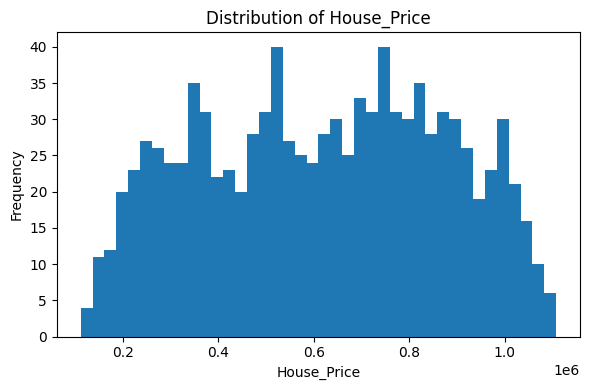

House_Price skewness: -0.064


In [65]:

target_col = 'House_Price'
print(f"Detected target column: {target_col}")

# ---------- Target distribution ----------
if target_col is not None and target_col in numeric_cols:
    # Histogram of target
    plt.figure(figsize=(6, 4))
    plt.hist(df[target_col].dropna(), bins=40)
    plt.xlabel(target_col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {target_col}")
    plt.tight_layout()
    plt.show()

    # Skewness and log-transform view if applicable
    skew_val = df[target_col].dropna().skew()
    print(f"{target_col} skewness: {skew_val:.3f}")
    if np.isfinite(skew_val) and abs(skew_val) > 1:
        plt.figure(figsize=(8, 5))
        plt.hist(np.log1p(df[target_col].dropna()), bins=40)
        plt.xlabel(f"log1p({target_col})")
        plt.ylabel("Frequency")
        plt.title(f"Log-transformed distribution of {target_col}")
        plt.tight_layout()
        plt.show()


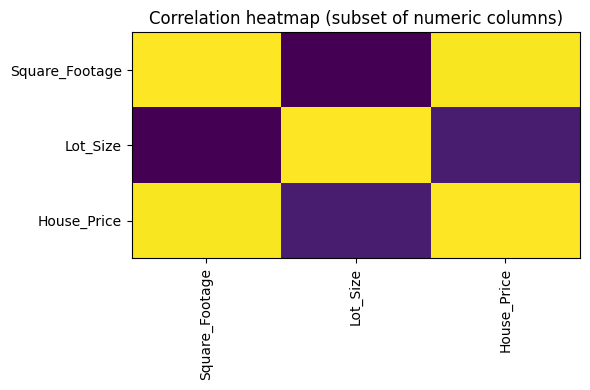

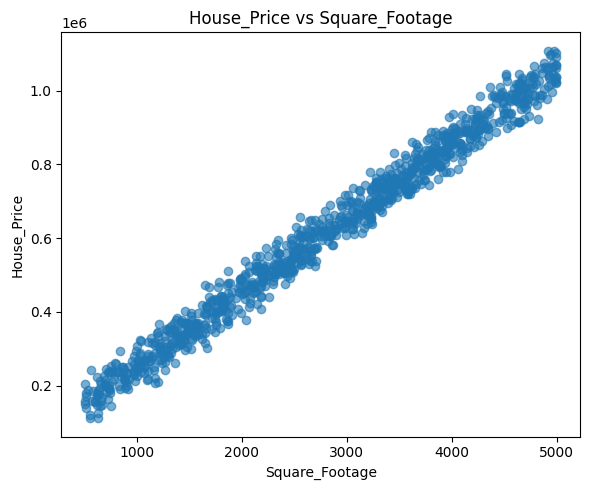

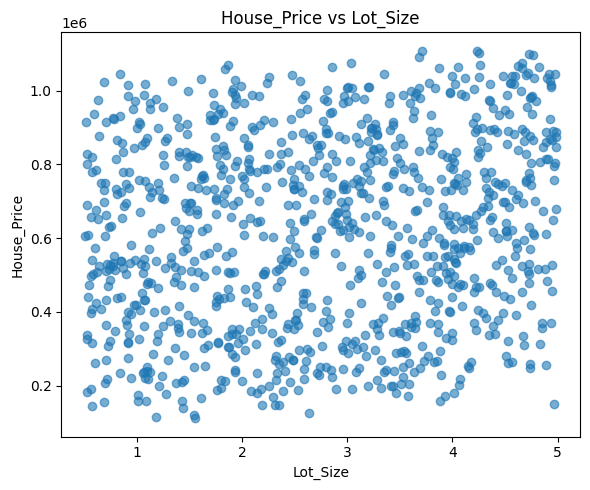

In [71]:
# ---------- Correlations

if numeric_cols:
    corr = df[numeric_cols].corr(numeric_only=True)
    # heatmap (cap to 30 columns for readability)
    cols_for_heatmap = numeric_cols[:min(30, len(numeric_cols))]
    plt.figure(figsize=(6, 4))
    plt.imshow(corr.loc[cols_for_heatmap, cols_for_heatmap], aspect="auto", interpolation="nearest")
    plt.xticks(range(len(cols_for_heatmap)), cols_for_heatmap, rotation=90)
    plt.yticks(range(len(cols_for_heatmap)), cols_for_heatmap)
    plt.title("Correlation heatmap (subset of numeric columns)")
    plt.tight_layout()
    plt.show()


    # Top correlations with target
    if target_col in corr.columns:
        target_corr = corr[target_col].drop(labels=[target_col]).sort_values(ascending=False)
        top_pos = target_corr.head(10)
        top_neg = target_corr.tail(10)
        corr_tbl = pd.DataFrame({
            "feature": target_corr.index,
            "corr_with_target": target_corr.values
        }).sort_values("corr_with_target", ascending=False)
        #display_dataframe_to_user("Correlation with target (sorted)", corr_tbl)

        # Scatter plots for top correlated features
        top_feats = list(top_pos.index[:6])
        for feat in top_feats:
            if feat in df.columns:
                plt.figure(figsize=(6, 5))
                plt.scatter(df[feat], df[target_col], alpha=0.6)
                plt.xlabel(feat)
                plt.ylabel(target_col)
                plt.title(f"{target_col} vs {feat}")
                plt.tight_layout()
                plt.show()

/tmp/ipython-input-1260972521.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


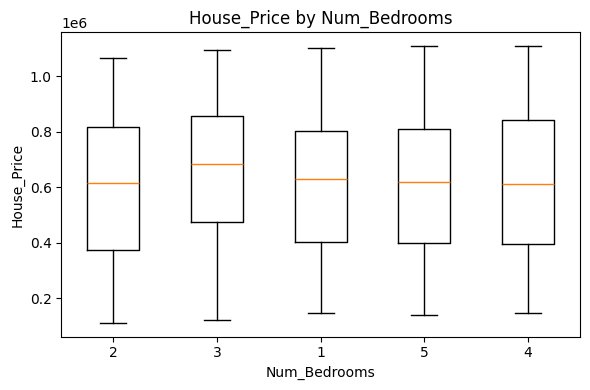

/tmp/ipython-input-1260972521.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


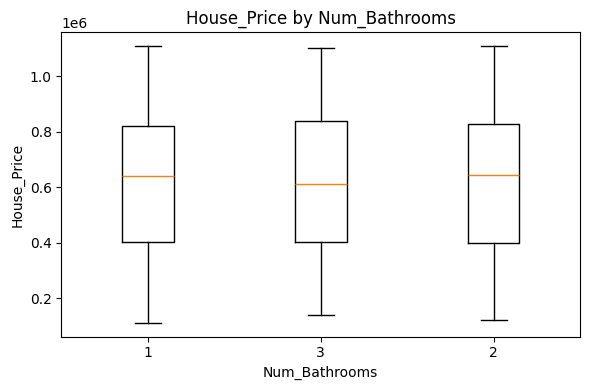

/tmp/ipython-input-1260972521.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


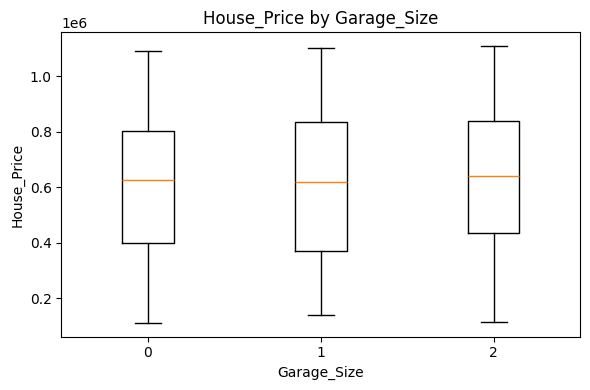

/tmp/ipython-input-1260972521.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


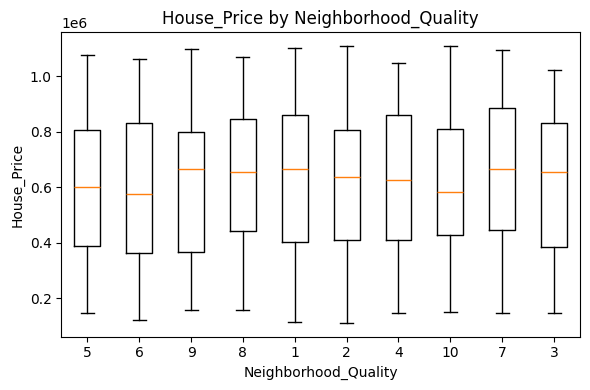

In [74]:
# ---------- Categorical analysis ----------
# Basic frequency for top categorical columns
cat_freq_summaries = []
for c in categorical_cols[:10]:
    vc = df[c].astype(str).value_counts().head(10)
    tmp = vc.rename_axis(c).reset_index(name="count")
    cat_freq_summaries.append((c, tmp))


# Boxplots of target vs low-cardinality categories
if target_col is not None and target_col in df.columns and target_col in numeric_cols:
    low_card_cats = [c for c in categorical_cols if df[c].nunique() <= 10 and df[c].nunique() >= 2]
    for c in low_card_cats[:6]:
        # prepare data grouped by category
        data = [df.loc[df[c] == k, target_col].dropna().values for k in df[c].dropna().unique()]
        labels = [str(k) for k in df[c].dropna().unique()]
        if len(data) >= 2:
            plt.figure(figsize=(6, 4))
            plt.boxplot(data, labels=labels, showfliers=True)
            plt.xlabel(c)
            plt.ylabel(target_col)
            plt.title(f"{target_col} by {c}")
            plt.tight_layout()
            plt.show()

/tmp/ipython-input-3406881709.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[feat].dropna().values, vert=True, labels=[feat], showfliers=True)


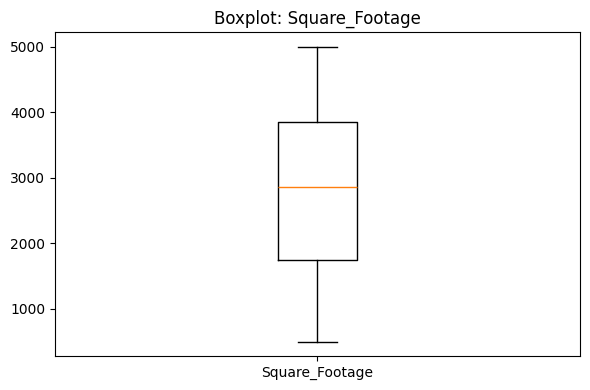

/tmp/ipython-input-3406881709.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[feat].dropna().values, vert=True, labels=[feat], showfliers=True)


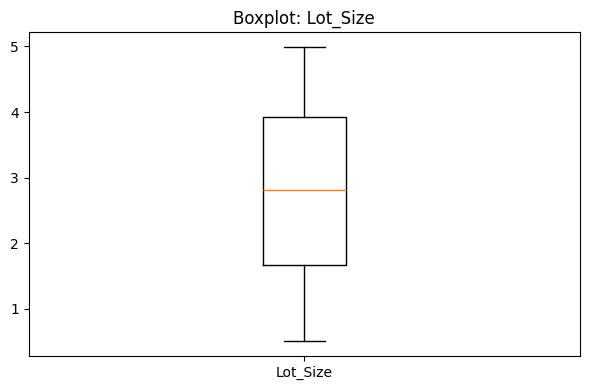

In [76]:
# ---------- Outlier checks ----------
# Boxplots for top 6 numeric features with highest variance (excluding target)
num_no_target = [c for c in numeric_cols if c != target_col]
variances = df[num_no_target].var(numeric_only=True).sort_values(ascending=False)
for feat in variances.index[:6]:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[feat].dropna().values, vert=True, labels=[feat], showfliers=True)
    plt.title(f"Boxplot: {feat}")
    plt.tight_layout()
    plt.show()